<h1 style="text-align: center; font-size: 500%; text-decoration: underline; font-weight: bold;">Concluding Assignment<h1>
<h2 style="text-align: center; font-size: 250%; font-weight: bold;">Ido Israeli (ID - 212432439)<br>Jonathan Derhy (ID - 315856377)<h2>
<h2 style="text-align: center; font-size: 400%; text-decoration: underline; font-weight: bold;">Part II<h2>

<h4 style="text-decoration: underline; font-weight: bold;">Imports<h4>

<h5 style="font-size: 95%">General Imports</h5>

In [1857]:
import sys
# import string
import numpy as np
import pandas as pd
# import math
import matplotlib.pyplot as plt

<h5 style="font-size: 95%">Specific Imports</h5>

In [1858]:
from typing import Union, Optional
from numpy.typing import ArrayLike
from functools import reduce
from matplotlib.gridspec import GridSpec

<h5 style="font-size: 95%">Warnings Handling</h5>

In [1859]:
import warnings
warnings.filterwarnings('ignore')

<h5 style="text-decoration: underline; font-weight: bold;">Functions for Debugging</h5>

In [1860]:
#
def print_variable_data(variable, name=None):
    if not isinstance(name, str):
        name = "Unnamed Variable"
    print(f'-------------------{name}-------------------\n')
    print(f'Type: {type(variable)}')
    if isinstance(variable, np.ndarray): print(f'Shape: {variable.shape}')
    elif isinstance(variable, list): print(f'Shape: {len(variable)}')
    print(f'contents:\n{variable}')
    print("\n--------------------------------------\n")

#
def validate_instance(variable, type):
    if not isinstance(variable, type):
        print(f'ERROR!\nVariable must be an instance of {type}!')
        sys.exit(1)


<h3 style="text-decoration: underline; font-weight: bold;">Part A: Preparing the data to train a linear classifier<h3>

<h4 style=" font-weight: bold;">Functions for Selecting Train and Test Data</h4>

In [1861]:
#
def shuffle_dataframe(df):
    validate_instance(df, pd.DataFrame)
    return df.sample(frac=1)

#
def select_train_and_test_by_train_percentage(df, train_percentage, toShuffle=False):
    validate_instance(df, pd.DataFrame)
    if toShuffle:
        train = df.sample(frac=train_percentage)
        test = df.drop(train.index)
    elif ~toShuffle:
        num_of_train_entries = (int)(df.shape[0] * train_percentage)
        train = df.head(num_of_train_entries)
        test = df.tail(df.shape[0] - num_of_train_entries)
        
    return train, test

<h4 style=" font-weight: bold;">Functions for Data Format Manipulation</h4>

In [1862]:
#
def get_dictionary_from_1darray(keys):
    dictio = {}
    dictio.update({key:0 for key in keys})
    return dictio

#
def get_ndarray_from_dataframe(df):
    validate_instance(df, pd.DataFrame)
    # return df[df.columns[:]].values
    return np.array(df)

#
def extract_entries_with_specified_values_in_columns(df: pd.DataFrame,
                                                     columns: Union[str, tuple[str], list[str], np.ndarray],
                                                     values) -> pd.DataFrame:
    """
    Extracts the entries that have the specified values in the specified columns.
    
    :return: A pd.DataFrame consisting of only the entries that have the specified values in the specified columns.
    """
    if isinstance(columns, str): # if true - only a single column
        if not hasattr(values, '__iter__'): # if true - values is *not* a non-string iterable (e.g. list, tuple, np.ndarray)
            values = [values]
        return df.loc[df[columns].isin(values)]
    return df.loc[reduce(lambda x, y: x & y, [df[col] == val for col, val in zip(columns, values)])]

#
def extract_desired_features(df, features_list, disregard_capitalization=True):
    validate_instance(df, pd.DataFrame)
    validate_instance(features_list, list)

    if disregard_capitalization:
        features_list: list = [s.lower() for s in features_list if isinstance(s, str)]
    matching_columns: list = [col for col in df.columns if (col.lower() if disregard_capitalization else col) in features_list]
    
    return df[matching_columns]

#
def get_features_and_classification(entry):
    """
    Separates the features of an entry from its classification, assuming the classification is found at the last index.

    :param entry: An entry of an instance that includes both the features and the classification.

    :return: A tuple of the features at index 0 and the classification at index 1.
    """
    features = entry[:-1]
    classification = entry[-1]
    return features, classification

#
def separate_features_and_classifications_for_dataframe(df):
    """
    Separates the features of all the entries in a dataframe from their respective classification.
    Assumes that the classification is found at the last index of every row.

    :param df: A pandas.DataFrame that holds entries with both features and classifications.

    :return: A tuple of the features at index 0 and the classifications at index 1.

    :error: returns -1 if argument df is not an instance of pandas.DataFrame
    """
    validate_instance(df, pd.DataFrame)
    
    features = df[df.columns[:-1]].values
    classifications = df[df.columns[-1]].values
    return features, classifications

#
def separate_features_and_classifications_for_ndarray(arr):
    """
    Separates the features of all the entries in an ndarray from their respective classification.
    Assumes that the classification is found at the last index of every row.

    :param arr: A numpy.ndarray that holds entries with both features and classifications.

    :return: A tuple of the features at index 0 and the classifications at index 1.
    
    :error: returns -1 if argument arr is not an instance of numpy.ndarray
    """
    validate_instance(arr, np.ndarray)
    
    features = arr[:, :-1]
    classifications = arr[:, -1]
    return features, classifications

#
def separate_features_and_classifications_for_df_or_ndarray(table):
    """
    Separates the features of all the entries in a table from their respective classification.
    Assumes that the classification is found at the last index of every row.

    :param table: A numpy.ndarray or a pandas.DataFrame that holds entries with both features and classifications.

    :return: A tuple of the features at index 0 and the classifications at index 1.
    
    :error: returns -1 if argument table is not an instance of either numpy.ndarray or pandas.DataFrame
    """
    if isinstance(table, np.ndarray):
        return separate_features_and_classifications_for_ndarray(table)
    if isinstance(table, pd.DataFrame):
        return separate_features_and_classifications_for_dataframe(table)
    print(f'ERROR!\nArgument must be an instance of either numpy.ndarray or pandas.DataFrame !')
    return -1


<h4 style=" font-weight: bold;">Functions for Graphing Data</h4>

In [1863]:
#
def add_pie_chart(ax: plt.Axes,
                  values: pd.Series,
                  labels: Union[list, None]=None,
                  explode: Union[ArrayLike, None]=None,
                  colors: Union[ArrayLike, None]=None,
                  autopct: Union[str, None]=None,
                  wedges_width: float=1,
                  shadow: bool=False,
                  textfont: Union[int, None]=None) -> None:
    """
    Adds a pie chart to an axis given as argument.

    :param ax: The axis to which a pie chart will be added.

    :param values: The values of the chart.

    :param labels: The labels for the chart. If labels is None than the default labels will be taken.
                    In order to have no labels make labels an empty list (labels=[ ]).
    """
    ax.pie(
        values,
        labels= values.index if labels is None else labels if labels else None,
        explode= explode,
        autopct= autopct,
        colors= colors,
        shadow= shadow,
        wedgeprops= dict(width=wedges_width),
        textprops= None if textfont is None else dict(fontsize=textfont))
    
#
def colors_match_labels(label_color_dict: dict, labels: ArrayLike) -> list:
    return [label_color_dict[f'{label}'] for label in labels]

<h4 style="text-decoration: underline; font-weight: bold;">Data Extraction</h4>

In [1864]:
df = pd.read_csv('./Resources/Data/data.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


<h4 style="text-decoration: underline; font-weight: bold;">Dividing the Data into Train and Test</h4>

In [1865]:
number_of_all_entries: int = len(df.index)
train_percentage: float = 0.8
number_of_train_entries: int = round(train_percentage * number_of_all_entries)
number_of_test_entries: int = round((1 - train_percentage) * number_of_all_entries)

print(
    f'There are a total of {number_of_all_entries} entries.\n' +
    f'With the percentage of the train data being {train_percentage:.0%} of the total number of entries:\n' +
    f'There are a total of {number_of_train_entries} train entries\n' +
    f'and a total of {number_of_test_entries} test entries.\n' +
    f'\n({number_of_train_entries} + {number_of_test_entries} = {number_of_train_entries + number_of_test_entries})'
    )

There are a total of 8693 entries.
With the percentage of the train data being 80% of the total number of entries:
There are a total of 6954 train entries
and a total of 1739 test entries.

(6954 + 1739 = 8693)


In [1866]:
D_train, D_test = select_train_and_test_by_train_percentage(df, train_percentage)

In [1867]:
D_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,7376_01,Europa,True,E/477/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,0.0,Neutrin Mirinanty,True
6950,7377_01,Earth,True,G/1186/P,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Estine Steelerettt,False
6951,7379_01,Earth,False,F/1416/S,TRAPPIST-1e,20.0,False,9.0,0.0,1540.0,0.0,0.0,Annard Bryants,False
6952,7385_01,Earth,False,F/1417/S,PSO J318.5-22,19.0,False,40.0,0.0,77.0,572.0,0.0,Coracy Reyerson,False


In [1868]:
D_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6954,7388_01,Earth,True,G/1198/S,PSO J318.5-22,17.0,False,0.0,0.0,0.0,0.0,0.0,Sterry Mclardson,True
6955,7390_01,Earth,False,G/1190/P,TRAPPIST-1e,62.0,False,240.0,0.0,0.0,586.0,10.0,Isa Wiggs,False
6956,7391_01,Earth,True,G/1191/P,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,NaN,0.0,Joycey Coffmaney,False
6957,7392_01,Earth,True,G/1192/P,TRAPPIST-1e,37.0,False,0.0,0.0,0.0,0.0,0.0,Floyde Holton,False
6958,7393_01,Earth,False,E/478/P,NaN,40.0,False,0.0,0.0,0.0,7.0,782.0,Coracy Barks,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


We chose to have 80% of the data comprise our train dataset and have the remaining 20% comprise the test dataset.<br>
This is because, when attempting to classify data, a large enough training dataset is required so that<br>
we get a good distribution of features and classifications.<br>
We don't want to have a dataset in which all entries have the same classification, because that will make it so that<br>
when we try to classify an entry that should be classified as the opposite class, there would not be any neighbor to indicate that.<br>
Because all possible neighbors wouldn't be of that classification, there is no neighbor that would gravitate the result into being the correct one.<br>
<br>
A ratio of 80-20 or even 70-30 serves us well, because we are able to have a large enough training dataset while also having a sufficient amount of entries left for testing.<br>

<h4 style="text-decoration: underline; font-weight: bold;">Understanding the Raw Data</h4>

Before we pick and choose which attributes and features will be used to determine the classification,<br>
let's have a look at the data in a more indicative way<br>
<br>
We'll start by checking the very basics of the data - the columns, how many are there of each and their types:

In [1869]:
print("\t\t---Info---")
df.info()

		---Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


As shown, the Dataframe includes 8693 entries and 14 columns.<br>
There are 6 columns that are of the type `float64`, 7 of the type `object`, and 1 of type `bool`.<br>
We will refer to the 'float64' columns as "Numerical Features" or "Numerical Attributes",<br>
and we will refer to the 'object' columns as "Categorical Features" or "Categorical Attributes".<br>
The 'bool' column is the "Transported" column, which is the classification for the entry.<br>
<br>
An important thing to notice is that even though there are 8693 entries in the Dataframe, some columns have less than 8693 non-null entries.<br>
This means that those columns have some vacant cells.<br>
<br>
Let's see how many of those are in each column:

In [1870]:
missing_per_column_df = df.isnull().sum()
print("How many are missing in each column:")
missing_per_column_df

How many are missing in each column:


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Let's also display the amount of missing values as a percentage of the total

In [1871]:
print("Percentage of missing values in each column:")
missing_per_column_df_percentage = (missing_per_column_df/len(df.index)).apply(lambda val: f'{val:.0%}' if not val else f'{val:.3%}')
missing_per_column_df_percentage

Percentage of missing values in each column:


PassengerId         0%
HomePlanet      2.312%
CryoSleep       2.496%
Cabin           2.289%
Destination     2.094%
Age             2.059%
VIP             2.335%
RoomService     2.082%
FoodCourt       2.105%
ShoppingMall    2.393%
Spa             2.105%
VRDeck          2.163%
Name            2.301%
Transported         0%
dtype: object

We will need to account for those missing values later down the line. The most logical thing is to attempt to fill them by guessing.<br>
But guessing is a dangerous game that may affect our results, so we need to do it cautiously.<br>
There are three methods that we may utilize in order to fill the blanks:

<style>
    .grid {
        display: grid;
        grid-template-columns: max-content auto;
        grid-column-gap: 1vw;
    }

    .underlined {
        text-decoration: underline;
    }

    ol, ul {
        margin-left: 2vw;
    }
</style>
<sub>
<ol>
    <li>
        <div class="grid">
            <span class="underlined">Most Common:</span>
            <span>
                We fill the blanks with the value that is the most common in that particular column <b>amongst all the entries in the Dataframe</b>.
            </span>
        </div>
    </li>
    <br>
    <li>
        <div class="grid">
            <span class="underlined">Mean:</span>
            <span>
                We fill the blanks with the average value of the particular column. This can be used only when the values can be quantified and averaged.
            </span>
        </div>
    </li>
    <br>
    <li>
        <div class="grid">
            <span class="underlined">KNN Based:</span>
            <span>
                We fill a blank cell with the value that is the most common <b>amongst the k nearest neighbors</b>.<br>
                There are main two variations to this:
                <ul>
                    <li>
                        k nearest index-wise entries in the Dataframe
                    </li>
                    <li>
                        k nearest entries according to other columns that are probably related or at least indicative of the column with the missing value.
                    </li>
                </ul>
            </span>
        </div>
    </li>
<ol>
</sub>

Now let's take a look at how many unique values are in each column:

In [1872]:
df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

While some columns are bound to have a lot of unique values because of what the represent (e.g. RoomService, FoodCourt, Spa, etc.),<br>
some columns tell us that there's not a lot of variance within them.<br>
Another thing to mention is that some columns (i.e. PassengerId and Cabin) seem to have a lot of unique values,<br>
but in reality it's because of the way they are formatted. Later we might break them down into their components<br>
as some of them might be useful and insightful to us, and some might not be of any use.

Let's see what are the unique values of 'HomePlanet' and 'Destination':

In [1873]:
pd.DataFrame({"HomePlanet": df["HomePlanet"].unique(), "Destination": df["Destination"].unique()}).dropna().style.hide_index()


HomePlanet,Destination
Europa,TRAPPIST-1e
Earth,PSO J318.5-22
Mars,55 Cancri e


After doing this basic review for the entire dataset, let's do a brief review of the split data and see what about the train and test sets:

In [1874]:
missing_amount_percent = lambda df : (df.isnull().sum()).apply(lambda val: (val, f'{val:.0%}' if not (val:=val/len(df.index)) else f'{val:.3%}'))

In [1875]:
print("(Amount, Percentage) of missing values in each column of the train dataset:")
missing_amount_percent(D_train)


(Amount, Percentage) of missing values in each column of the train dataset:


PassengerId           (0, 0%)
HomePlanet      (161, 2.315%)
CryoSleep       (171, 2.459%)
Cabin           (162, 2.330%)
Destination     (150, 2.157%)
Age             (154, 2.215%)
VIP             (158, 2.272%)
RoomService     (150, 2.157%)
FoodCourt       (153, 2.200%)
ShoppingMall    (168, 2.416%)
Spa             (146, 2.100%)
VRDeck          (162, 2.330%)
Name            (165, 2.373%)
Transported           (0, 0%)
dtype: object

In [1876]:
print("(Amount, Percentage) of missing values in each column of the test dataset:")
missing_amount_percent(D_test)


(Amount, Percentage) of missing values in each column of the test dataset:


PassengerId          (0, 0%)
HomePlanet      (40, 2.300%)
CryoSleep       (46, 2.645%)
Cabin           (37, 2.128%)
Destination     (32, 1.840%)
Age             (25, 1.438%)
VIP             (45, 2.588%)
RoomService     (31, 1.783%)
FoodCourt       (30, 1.725%)
ShoppingMall    (40, 2.300%)
Spa             (37, 2.128%)
VRDeck          (26, 1.495%)
Name            (35, 2.013%)
Transported          (0, 0%)
dtype: object

In [1877]:
# Deleting some unnecessary variables to reduce memory usage
globals().pop('missing_per_column_df', None);
globals().pop('missing_per_column_df_percentage', None);
globals().pop('missing_amount_percent', None);

Now that we did a "shallow" overview of the data at hand, let's delve deeper and get more insight into<br>
the relations between the attributes and the classification.

Let's start by displaying how many passangers have teleported vs how many didn't:

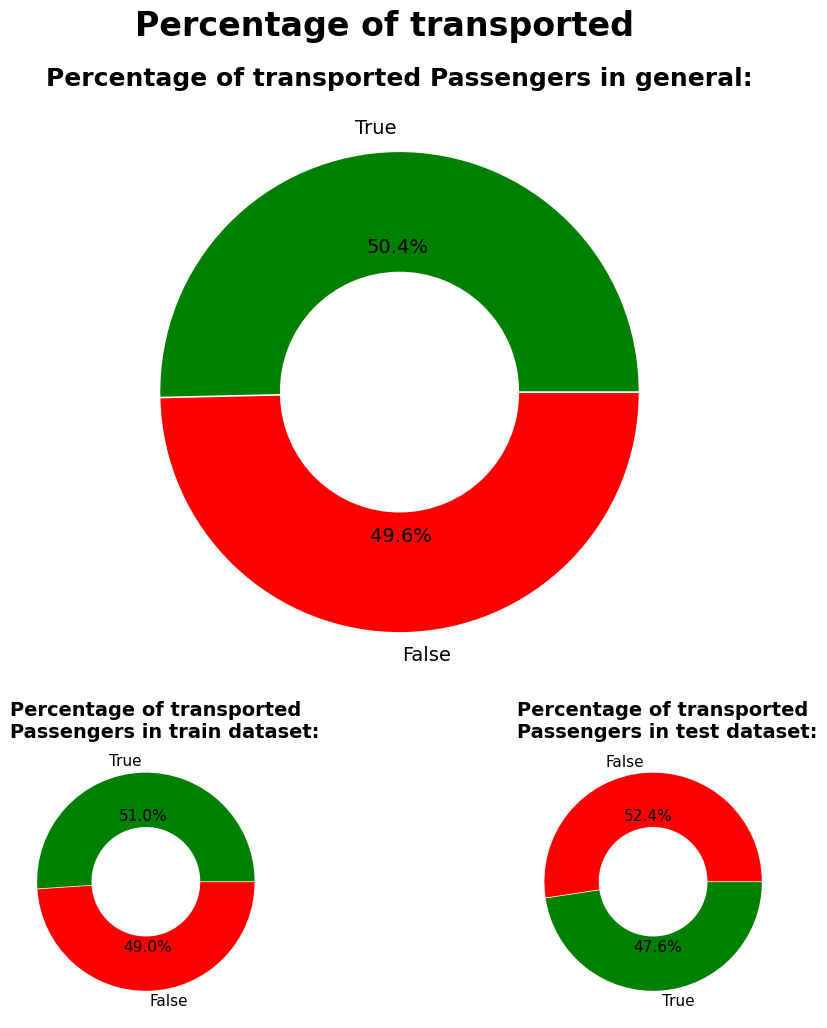

In [1878]:
transported = df['Transported'].value_counts()
transported_train = D_train['Transported'].value_counts()
transported_test = D_test['Transported'].value_counts()

fig = plt.figure(figsize=(12,12))
gs = GridSpec(3, 2, figure=fig)

# Updating the rcParams in Matplotlib
# Making every title bold
plt.rcParams.update({'axes.titleweight': 'bold'})

explode = [0.007, 0]
autopct = '%1.1f%%' # In order to display as a percentage with one decimal point
label_color_dict = {
    'True': 'green',
    'False': 'red',
}

# Pie chart for all the data
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))
ax1.set_title("Percentage of transported Passengers in general:", fontsize=18)
colors = colors_match_labels(label_color_dict, transported.keys())
add_pie_chart(ax1, transported, explode=explode, colors=colors, autopct=autopct, wedges_width=0.5, textfont=14)

plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 11,
    'axes.titlelocation': 'left'
})

# Pie chart for the train data
ax2 = plt.subplot(gs.new_subplotspec((2, 0), colspan=1, rowspan=1))
ax2.set_title("Percentage of transported\nPassengers in train dataset:")
colors = colors_match_labels(label_color_dict, transported_train.keys())
add_pie_chart(ax2, transported_train, explode=explode, colors=colors, autopct=autopct, wedges_width=0.5, textfont=11)

# Pie chart for the test data
ax3 = plt.subplot(gs.new_subplotspec((2, 1), colspan=1, rowspan=1))
ax3.set_title("Percentage of transported\nPassengers in test dataset:")
colors = colors_match_labels(label_color_dict, transported_test.keys())
add_pie_chart(ax3, transported_test, explode=explode, colors=colors, autopct=autopct, wedges_width=0.5, textfont=11)

fig.suptitle("Percentage of transported", fontsize=24, fontweight='bold', y=0.95)
plt.show()

# Restoring rcParams back to default values
plt.rcParams.update(plt.rcParamsDefault)

<style>
    td {
        text-align: center;
        font-size: 90%;
    }

    .larger {
        color: orange;
        font-weight: bold;
    }

    .smaller {
        
    }
</style>
And as a table:
<table>
    <tr>
        <td style="border-style: none;"></td>
        <th>Teleported%</th>
        <th>Didn't%</th>
    </tr>
    <tr>
        <th>Entire Dataset</th>
        <td><span class="larger">50.4%</span></td>
        <td><span class="smaller">49.6%</span></td>
    </tr>
    <tr>
        <th>Train Dataset</th>
        <td><span class="larger">51%</span></td>
        <td><span class="smaller">49%</span></td>
    </tr>
    <tr>
        <th>Test Dataset</th>
        <td><span class="smaller">47.6%</span></td>
        <td><span class="larger">52.4%</span></td>
    </tr>
</table>

We can see that about half of the passangers have teleported to a different dimension.<br>
We can also see that the percentage of those who teleported is relatively unchanged when we split the data.

<h4 style="text-decoration: underline; font-weight: bold;">Picking the Desired Attributes</h4>

We want to take into account features that seem relevant

<style>
    h5 {
        text-decoration: underline;
        font-size: 95%;
    }

    ol {
        border-style: solid;
    }

    li {
        font-size: 80%;
    }
    
    .bolded {
        font-weight: bold;
    }

    .underlined {
        text-decoration: underline;
    }
</style>

<h5>Attributes Picked:</h5>
<ol>
    <li><span class="underlined bolded">Passenger ID :</span> We chose...</li>
    <li><span class="underlined bolded">Home Planet :</span> We chose...</li>
    <li><span class="underlined bolded">Destination :</span> We chose...</li>
    <li><span class="underlined bolded">Cabin :</span> We chose...</li>
</ol>

<h5>Attributes Not-Picked:</h5>
<ol>
    <li><span class="underlined bolded">Passenger ID :</span> We chose...</li>
    <li><span class="underlined bolded">Home Planet :</span> We chose...</li>
    <li><span class="underlined bolded">Destination :</span> We chose...</li>
    <li><span class="underlined bolded">Cabin :</span> We chose...</li>
</ol>

<h5>Attributes Added:</h5>
<ol>
    <li><span class="underlined bolded">Passenger ID :</span> We chose...</li>
    <li><span class="underlined bolded">Home Planet :</span> We chose...</li>
    <li><span class="underlined bolded">Destination :</span> We chose...</li>
    <li><span class="underlined bolded">Cabin :</span> We chose...</li>
</ol>

In [1879]:
features_list = ["PassengerId", "HomePlanet", "Destination", "Cabin"]

In [1880]:
D_train = extract_desired_features(D_train, features_list, disregard_capitalization=True)

In [1881]:
D_train

,PassengerId,HomePlanet,Cabin,Destination
0,0001_01,Europa,B/0/P,TRAPPIST-1e
1,0002_01,Earth,F/0/S,TRAPPIST-1e
2,0003_01,Europa,A/0/S,TRAPPIST-1e
3,0003_02,Europa,A/0/S,TRAPPIST-1e
4,0004_01,Earth,F/1/S,TRAPPIST-1e
...,...,...,...,...
6949,7376_01,Europa,E/477/P,TRAPPIST-1e
6950,7377_01,Earth,G/1186/P,PSO J318.5-22
6951,7379_01,Earth,F/1416/S,TRAPPIST-1e
6952,7385_01,Earth,F/1417/S,PSO J318.5-22


In [1882]:
D_test = extract_desired_features(D_test, features_list, disregard_capitalization=True)

In [1883]:
D_test

,PassengerId,HomePlanet,Cabin,Destination
6954,7388_01,Earth,G/1198/S,PSO J318.5-22
6955,7390_01,Earth,G/1190/P,TRAPPIST-1e
6956,7391_01,Earth,G/1191/P,TRAPPIST-1e
6957,7392_01,Earth,G/1192/P,TRAPPIST-1e
6958,7393_01,Earth,E/478/P,NaN
...,...,...,...,...
8688,9276_01,Europa,A/98/P,55 Cancri e
8689,9278_01,Earth,G/1499/S,PSO J318.5-22
8690,9279_01,Earth,G/1500/S,TRAPPIST-1e
8691,9280_01,Europa,E/608/S,55 Cancri e


In [1884]:
# df1 = df[(df['Age'] == 24) & (df['Transported'].values)]
# df1 = df[df['Age'].isin((24, 39))]
columns = ['Age', 'Transported']
values = [24, True]
df1 = df[reduce(lambda x, y: x & y, [df[col] == val for col, val in zip(columns, values)])]
# df1 = df[['Age', 'Transported']]
df1

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
78,0084_01,Earth,False,G/14/S,TRAPPIST-1e,24.0,False,688.0,0.0,0.0,0.0,17.0,Coren Coopezmaney,True
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,0.0,17.0,Arlen Mclainez,True
115,0120_01,Mars,True,F/25/P,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,NaN,Bees Sacre,True
130,0140_01,Earth,True,G/19/P,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Evaley Mejiaddox,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,8926_01,Earth,False,E/571/P,TRAPPIST-1e,24.0,False,0.0,NaN,3.0,80.0,0.0,Paulah Pooles,True
8355,8939_01,Earth,True,G/1441/S,PSO J318.5-22,24.0,False,0.0,0.0,0.0,0.0,0.0,Jillie Sweett,True
8596,9176_01,Earth,False,F/1773/S,TRAPPIST-1e,24.0,False,0.0,537.0,0.0,5.0,197.0,Willy Mcneiderson,True
8611,9192_01,Earth,False,F/1880/P,PSO J318.5-22,24.0,False,NaN,599.0,NaN,0.0,0.0,Norahe Drakeekss,True


In [1885]:
# df2 = df.loc[(df['Age'] == 24) & (df['Transported'].values)]
# df2 = df.loc[df['Age'].isin((24, 39))]
df2 = df.loc[reduce(lambda x, y: x & y, [df[col] == val for col, val in zip(columns, values)])]
df2

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
78,0084_01,Earth,False,G/14/S,TRAPPIST-1e,24.0,False,688.0,0.0,0.0,0.0,17.0,Coren Coopezmaney,True
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,0.0,17.0,Arlen Mclainez,True
115,0120_01,Mars,True,F/25/P,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,NaN,Bees Sacre,True
130,0140_01,Earth,True,G/19/P,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Evaley Mejiaddox,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,8926_01,Earth,False,E/571/P,TRAPPIST-1e,24.0,False,0.0,NaN,3.0,80.0,0.0,Paulah Pooles,True
8355,8939_01,Earth,True,G/1441/S,PSO J318.5-22,24.0,False,0.0,0.0,0.0,0.0,0.0,Jillie Sweett,True
8596,9176_01,Earth,False,F/1773/S,TRAPPIST-1e,24.0,False,0.0,537.0,0.0,5.0,197.0,Willy Mcneiderson,True
8611,9192_01,Earth,False,F/1880/P,PSO J318.5-22,24.0,False,NaN,599.0,NaN,0.0,0.0,Norahe Drakeekss,True


In [1886]:
df1.equals(df2)

True